In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# NOTE: SIFT is not in the newest OpenCV
# Install OpenCV 3.4.2
# -------------
# pip uninstall opencv-python
# pip install opencv-python==3.4.2.16
# pip install opencv-contrib-python==3.4.2.16
# -------------
# Display Unknow Class Object Attributes

# keypoint = kp1[0]
# def dump(obj):
#     for attr in dir(obj):
#         print("obj.%s = %r" % (attr, getattr(obj, attr)))
# dump(keypoint)
# dump(matches[0])
def generateKeypoints(img1_path, img2_path):
    img1 = cv2.imread(img1_path)
    img1 = cv2.resize(img1, (1024, 1024))
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    img2 = cv2.imread(img2_path)
    img2 = cv2.resize(img2, (1024, 1024))
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # ORB Detector
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1_gray, None)
    kp2, des2 = orb.detectAndCompute(img2_gray, None)

    # Brute Force Matching
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.match(des1, des2)
    return [img1, img2, kp1, kp2, matches]

import random
def generatePalettes(n = 30):
    steps = int(255/(pow(n, 1/3)))
    colors = []
    for R in range(0, 256, steps):
        for G in range(0, 256, steps):
            for B in range(0, 256, steps):
                colors.append(tuple([R, G, B]))
    #random.shuffle(colors)
    colors = random.sample(colors, n)
    random.shuffle(colors)
    return colors

def drawOneDot(coord, image, color = (255, 0, 0) ):
    thickness = -1
    radius = 15
    cv2.circle(image, coord, radius, color, thickness)

    
def calDistance(p1, p2):
    return int(pow(pow(p1[0] - p2[0], 2) + pow(p1[1] - p2[1], 2), 0.5))
    
def canBeDrew(point, showPoints, distanceThreshold = 20):
    if len(showPoints) == 0:
        showPoints.add(point)
        return True
    for p in showPoints:
        if calDistance(point, p) < distanceThreshold:
            return False
    showPoints.add(point)
    return True

  
        
def drawNDots(img1, img2, kp1, kp2, matchRecords, n = 10):
    matchRecords.sort(key = lambda x:x.distance)
    colors = generatePalettes(n = n)
    color_idx = 0
    
    showPoints = set()
    threshhold = int(img1.shape[0]/20)
    
    for m in matchRecords:

        p1 = kp1[m.queryIdx].pt
        p1 = tuple([int(c) for c in p1])
        if canBeDrew(p1, showPoints, threshhold):
            #print(m.distance)
            p2 = kp2[m.trainIdx].pt
            p2 = tuple([int(c) for c in p2])
            
            drawOneDot(p1, img1, colors[color_idx])
            drawOneDot(p2, img2, colors[color_idx])
            color_idx += 1
            if color_idx == n:
                break

            
def checkDuplicatedImages(img1, img2, kp1, kp2, matchRecords, n = 10):
    matchRecords.sort(key = lambda x:x.distance)
    colors = generatePalettes(n = n)
    color_idx = 0
    
    img1_FeaturePoints = []
    img2_FeaturePoints = []
    trackPoints = set(img1_FeaturePoints)
    
    threshhold = int(img1.shape[0]/20)
    
    for m in matchRecords:
        p1 = kp1[m.queryIdx].pt
        p1 = tuple([int(c) for c in p1])
        if canBeDrew(p1, trackPoints, threshhold) and m.distance < 30:
            p2 = kp2[m.trainIdx].pt
            p2 = tuple([int(c) for c in p2])
            img1_FeaturePoints.append(p1)
            img2_FeaturePoints.append(p2)
    #print(img1_FeaturePoints)
    
    if len(img1_FeaturePoints) >= 10:
        img1_FeaturePoints.sort(key = lambda x:x[0])
        dx1 = calDistance(img1_FeaturePoints[0], img1_FeaturePoints[1])
        img1_FeaturePoints.sort(key = lambda x:x[1])
        dy1 = calDistance(img1_FeaturePoints[0], img1_FeaturePoints[1])
        
        img2_FeaturePoints.sort(key = lambda x:x[0])
        dx2 = calDistance(img2_FeaturePoints[0], img2_FeaturePoints[1])
        img2_FeaturePoints.sort(key = lambda x:x[1])
        dy2 = calDistance(img2_FeaturePoints[0], img2_FeaturePoints[1])
        
        if dx1 >= dx2 and dy1 >= dy2:
            return 2
        else:
            return 1
    else:
        return 0 #return 0 means it is not duplicate. 1 means first image is main image, 2 means second image is main

def plotImages(img1, img2, kp1, kp2, matches, result, numPoints):
    if result == 0:
        print('The images below are not same')
    elif result == 1:
        print('For images below... Left: Main Image  |  Right: Cropped Image')
    elif result == 2:
        print('For images below... Left: Cropped Image  |  Right: Main Image')
    drawNDots(img1, img2, kp1, kp2, matches, n = numPoints)
    f = plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
    f.add_subplot(1,2, 1)
    plt.imshow(img1)
    f.add_subplot(1,2, 2)
    plt.imshow(img2)
    plt.show()
    
def predict(img1_path, img2_path, numPoints = 20 , displayImages = False):
    img1, img2, kp1, kp2, matches = generateKeypoints(img1_path, img2_path)
    result = checkDuplicatedImages(img1, img2, kp1, kp2, matches, n = numPoints)
    if displayImages:
        plotImages(img1, img2, kp1, kp2, matches, result, numPoints)
    return result

For images below... Left: Main Image  |  Right: Cropped Image


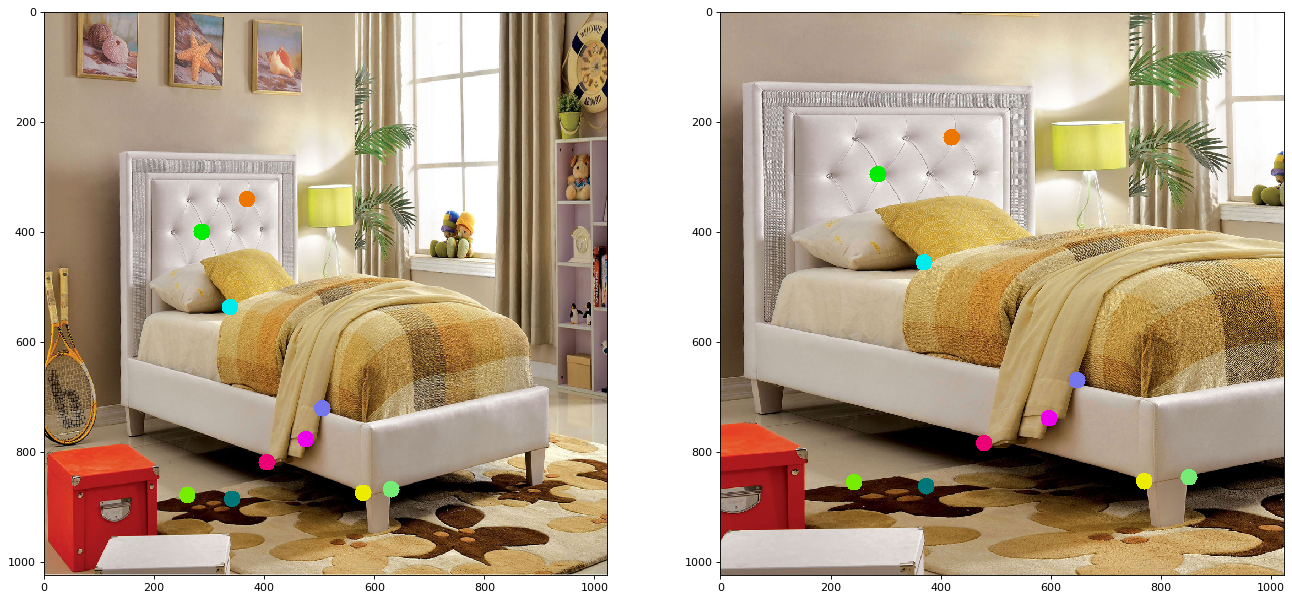

In [2]:
result = predict('./images/bed1.jpg', './images/bed2.jpg', numPoints = 10, displayImages = True)

The images below are not same


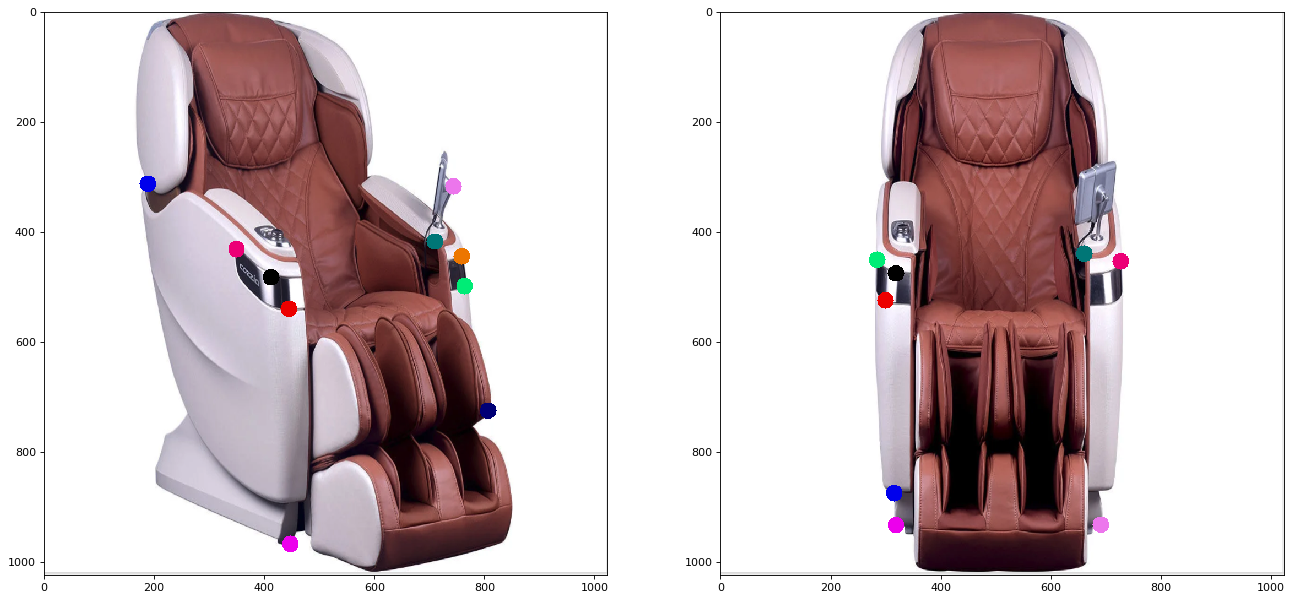

In [3]:
result = predict('./images/chair1.png', './images/chair2.png', numPoints = 10, displayImages = True)

For images below... Left: Cropped Image  |  Right: Main Image


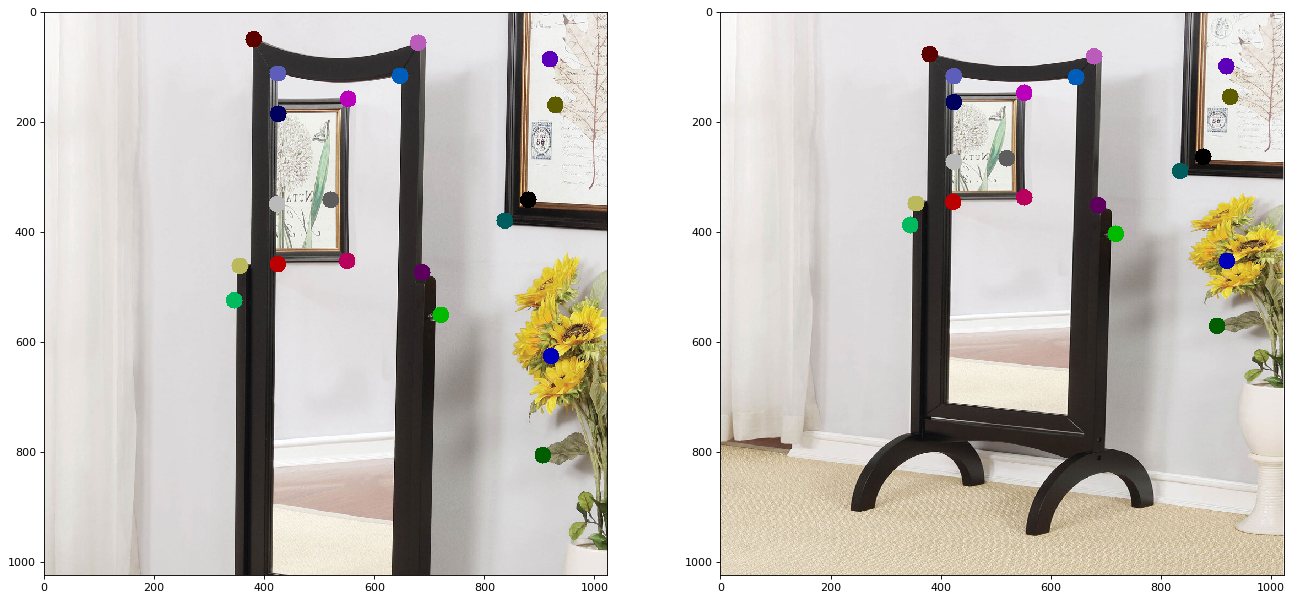

In [4]:
result = predict('./images/mirror1.jpg', './images/mirror2.jpg', numPoints = 20, displayImages = True)

For images below... Left: Main Image  |  Right: Cropped Image


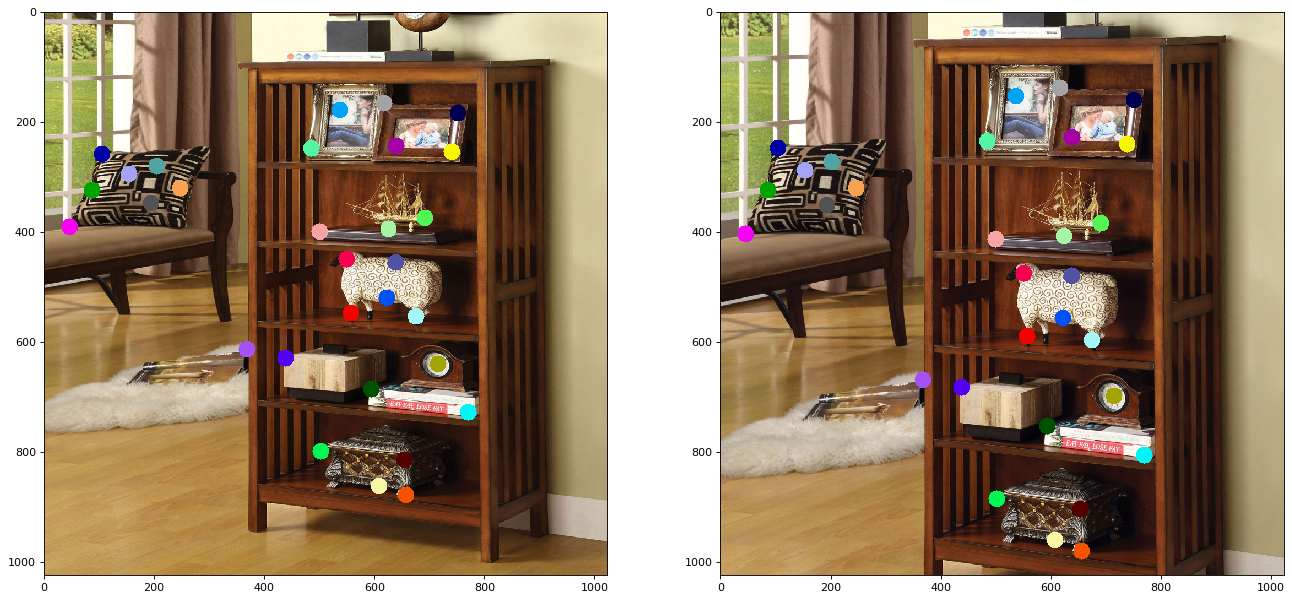

In [5]:
result = predict('./images/shelf1.jpg', './images/shelf2.jpg',numPoints = 30, displayImages = True)

For images below... Left: Main Image  |  Right: Cropped Image


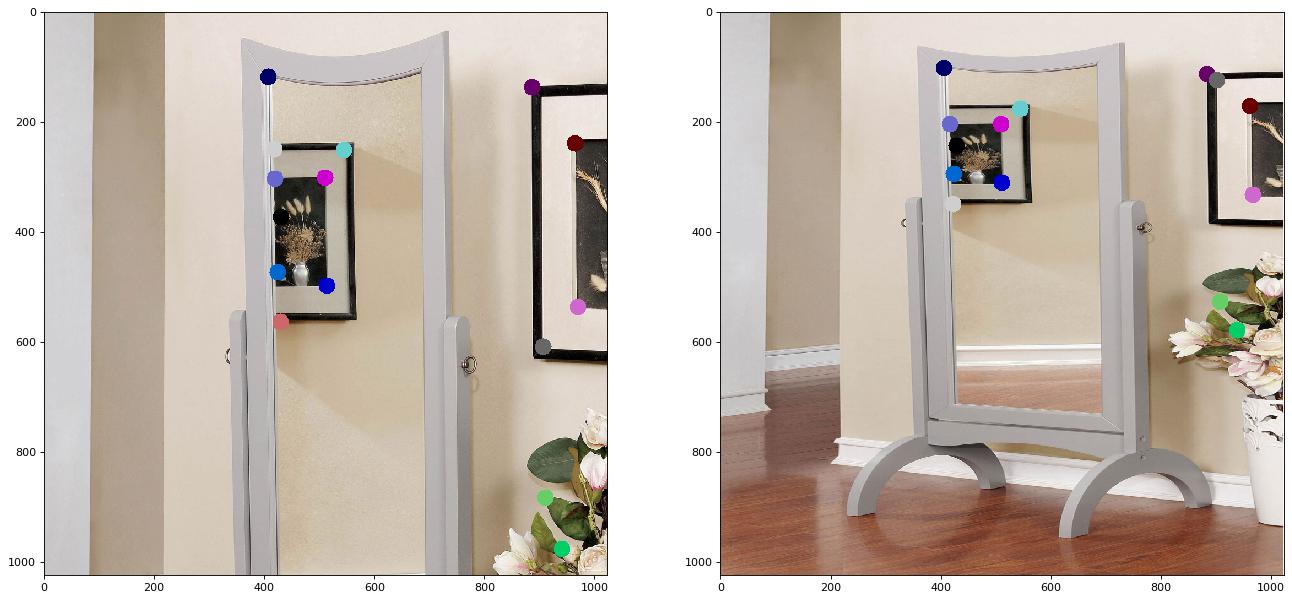

In [6]:
result = predict('./images/whitemirror1.jpg', './images/whitemirror2.jpg', numPoints = 15,displayImages = True)

Failed Case Note: This is a different image taken at another angle